In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import json
import copy
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import seaborn as sn

In [2]:
def clean_age(value):
    if value < 18:
        return "Youth"
    elif value >= 18 and value <=35:
        return "Young Adult"
    elif value  >= 36 and value <=55:
        return "Adult"
    else:
        return "Senior"

In [3]:
def map_prediction(value):
    if value == 1:
        return True
    else:
        return False

In [4]:
def percentage_of_false_positives_pred(group, threshold=0):
    false_positives = group[(group.prediction == True) & (group.ContrabandIndicator == False)].shape[0]
    n_vehicle_searched = group[(group.prediction == True)].shape[0]
    if n_vehicle_searched > threshold:
        return 100*false_positives/n_vehicle_searched
    else:
        return None

In [5]:
def percentage_of_true_positives_pred(group, threshold=0):
    true_positives = group[(group.prediction == True) & (group.ContrabandIndicator == True)].shape[0]
    n_vehicle_searched = group[(group.prediction == True)].shape[0]
    if n_vehicle_searched > threshold:
        return 100*true_positives/n_vehicle_searched
    else:
        return None

In [6]:
def percentage_of_false_positives_vsi(group, threshold=0):
    false_positives = group[(group.VehicleSearchedIndicator == True) & (group.ContrabandIndicator == False)].shape[0]
    n_vehicle_searched = group[(group.VehicleSearchedIndicator == True)].shape[0]
    if n_vehicle_searched > threshold:
        return 100*false_positives/n_vehicle_searched
    else:
        return None

In [7]:
def percentage_of_true_positives_vsi(group, threshold=0):
    true_positives = group[(group.VehicleSearchedIndicator == True) & (group.ContrabandIndicator == True)].shape[0]
    n_vehicle_searched = group[(group.VehicleSearchedIndicator == True)].shape[0]
    if n_vehicle_searched > threshold:
        return 100*true_positives/n_vehicle_searched
    else:
        return None

In [8]:
def evaluate_bias(row):
    row_ = copy.copy(row)
    n_nulls = len(row[pd.isna(row)])
    len_row = len(row)
    n_not_nulls = len_row - n_nulls
    row_ = row_.dropna()
    if n_not_nulls > 1:
        return max(row_) - min(row_)
    else:
        None  

In [9]:
def diffs(row):
    row_ = copy.copy(row)
    n_nulls = len(row[pd.isna(row)])
    len_row = len(row)
    n_not_nulls = len_row - n_nulls
    row_ = row_.dropna()
    array = row_.values
    if n_not_nulls > 1:
        diff = []
        for i in range(0, len(array)-1):
            for j in range(i+1, len(array)):
                diff.append(abs(array[i]-array[j]))
        return diff
    else:
        return None  

In [10]:
def evaluate_bias_by_group(df, group, threshold=100, prediction=False):
    if prediction == False:
        police_src = df.groupby(by=group).apply(lambda x: percentage_of_true_positives_vsi(x, threshold))
    else:
        police_src = df.groupby(by=group).apply(lambda x: percentage_of_true_positives_pred(x, threshold))
    result = police_src.unstack(level=[1,2,3,4])
    result["Max Diff"] = result.apply(evaluate_bias, axis=1)
    result = result.sort_values(by="Max Diff", ascending=False)
    result["Diff"] = result.drop(columns="Max Diff").apply(diffs, axis=1)
    result = result[(pd.isna(result["Max Diff"])!=True)]
    return result

In [11]:
def map_prediction(value):
    if value == 1:
        return True
    else:
        return False

## Performance of model, trainned with all data, in production

In [12]:
df = pd.read_csv("resources/predictions_production.csv", index_col=0, names=["id", "obs", "prob", "true", "pred"])

In [13]:
df.head()

,id,obs,prob,true,pred
7816,7376,"{""id"": 7376, ""observation"": {""Department Name""...",0.516830,NaN,1
442,1,"{""id"": 1, ""observation"": {""Department Name"": ""...",0.514043,0.0,1
443,2,"{""id"": 2, ""observation"": {""Department Name"": ""...",0.520429,1.0,1
444,3,"{""id"": 3, ""observation"": {""Department Name"": ""...",0.520429,1.0,1
445,4,"{""id"": 4, ""observation"": {""Department Name"": ""...",0.521419,0.0,1


In [14]:
df.shape

(9999, 5)

In [15]:
df_ = df.dropna()
df_.shape

(4999, 5)

In [16]:
obs = df_.obs.apply(lambda x: json.loads(x)["observation"])

In [17]:
df_production = pd.DataFrame.from_dict(list(obs.values))
df_production 

,Department Name,InterventionDateTime,InterventionLocationName,InterventionReasonCode,ReportingOfficerIdentificationID,ResidentIndicator,SearchAuthorizationCode,StatuteReason,SubjectAge,SubjectEthnicityCode,SubjectRaceCode,SubjectSexCode,TownResidentIndicator
0,Vernon,05/16/2018 02:39:00 AM,VERNON,V,625,False,C,Registration,40.0,N,B,M,False
1,Milford,05/16/2018 04:08:00 AM,MILFORD,E,473,True,I,Other,49.0,N,B,F,False
2,Milford,05/16/2018 04:08:00 AM,MILFORD,E,473,True,I,Other,49.0,N,B,F,False
3,Norwalk,05/16/2018 09:38:00 AM,NORWALK,V,100000335,True,I,Defective Lights,35.0,N,W,M,True
4,Norwalk,05/16/2018 09:38:00 AM,NORWALK,V,100000335,True,I,Defective Lights,35.0,N,W,M,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4994,Willimantic,07/12/2018 10:07:00 AM,WILLIMANTIC,E,398,True,C,Defective Lights,40.0,N,W,F,False
4995,Hartford,07/12/2018 02:50:00 PM,Hartford,V,3145,False,C,Moving Violation,40.0,N,B,M,True
4996,East Hartford,07/12/2018 04:49:00 PM,EAST HARTFORD,V,215,True,N,Other,43.0,N,W,M,True
4997,East Hartford,07/12/2018 05:37:00 PM,EAST HARTFORD,V,219,True,O,Administrative Offense,25.0,N,B,M,True


In [18]:
df_production["ContrabandIndicator"] = df_["true"].values
df_production["prediction"] = df_["pred"].values

In [19]:
df_production.SearchAuthorizationCode.value_counts()

O    2093
C    1490
I    1272
N     144
Name: SearchAuthorizationCode, dtype: int64

In [20]:
df_production.groupby("SearchAuthorizationCode").ContrabandIndicator.value_counts()

SearchAuthorizationCode  ContrabandIndicator
C                        0.0                    1056
                         1.0                     434
I                        0.0                    1090
                         1.0                     182
N                        0.0                     108
                         1.0                      36
O                        1.0                    1142
                         0.0                     951
Name: ContrabandIndicator, dtype: int64

In [21]:
df_production.groupby("SearchAuthorizationCode").prediction.value_counts()

SearchAuthorizationCode  prediction
C                        1             1490
I                        1             1272
N                        0              144
O                        1             2093
Name: prediction, dtype: int64

In [22]:
def decode_target(value):
    if value == 1:
        return True
    else:
        return False

In [23]:
def encode_target(value):
    if value == True:
        return 1
    else:
        return 0

In [24]:
df_production["ContrabandIndicator"] = df_production["ContrabandIndicator"].apply(decode_target)

In [25]:
df_production.head()

,Department Name,InterventionDateTime,InterventionLocationName,InterventionReasonCode,ReportingOfficerIdentificationID,ResidentIndicator,SearchAuthorizationCode,StatuteReason,SubjectAge,SubjectEthnicityCode,SubjectRaceCode,SubjectSexCode,TownResidentIndicator,ContrabandIndicator,prediction
0,Vernon,05/16/2018 02:39:00 AM,VERNON,V,625,False,C,Registration,40.0,N,B,M,False,False,1
1,Milford,05/16/2018 04:08:00 AM,MILFORD,E,473,True,I,Other,49.0,N,B,F,False,True,1
2,Milford,05/16/2018 04:08:00 AM,MILFORD,E,473,True,I,Other,49.0,N,B,F,False,True,1
3,Norwalk,05/16/2018 09:38:00 AM,NORWALK,V,100000335,True,I,Defective Lights,35.0,N,W,M,True,False,1
4,Norwalk,05/16/2018 09:38:00 AM,NORWALK,V,100000335,True,I,Defective Lights,35.0,N,W,M,True,False,1


In [26]:
df_production.to_csv("resources/production_data.csv")

In [27]:
df_production["SubjectAge"] = df_production["SubjectAge"].apply(clean_age)

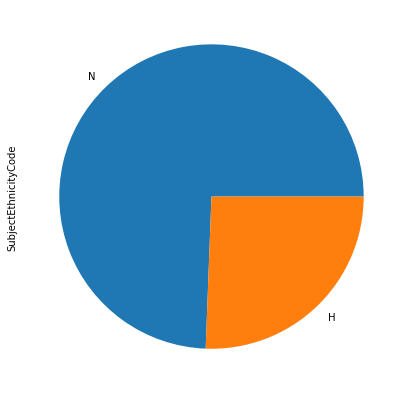

In [28]:
df_production.SubjectEthnicityCode.value_counts().plot.pie(y="SubjectEthnicityCode", figsize=(7, 7))

In [29]:
100*df_production.SubjectEthnicityCode.value_counts()/len(df_production)

N    74.394879
H    25.605121
Name: SubjectEthnicityCode, dtype: float64

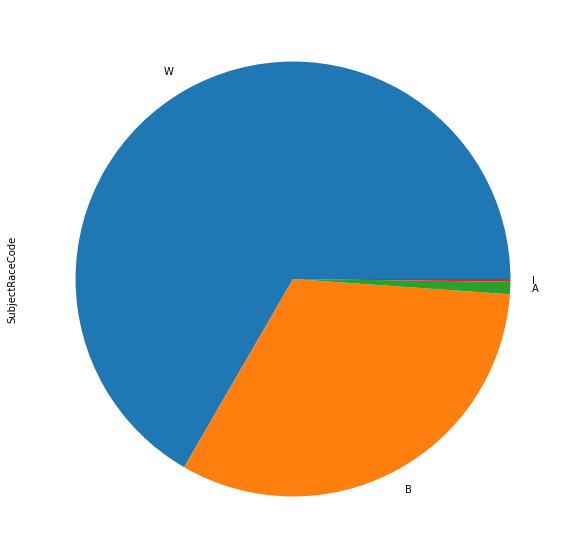

In [30]:
df_production.SubjectRaceCode.value_counts().plot.pie(y="SubjectRaceCode", figsize=(10, 10))

In [31]:
100*df_production.SubjectRaceCode.value_counts()/len(df_production)

W    66.653331
B    32.226445
A     0.920184
I     0.200040
Name: SubjectRaceCode, dtype: float64

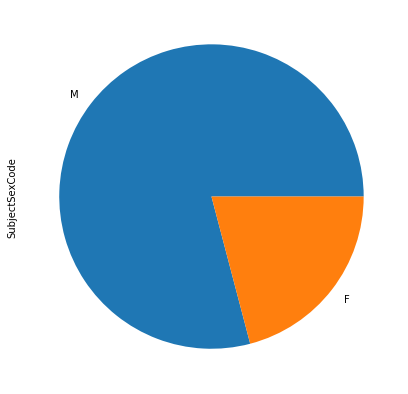

In [32]:
df_production.SubjectSexCode.value_counts().plot.pie(y="SubjectSexCode", figsize=(7, 7))

In [33]:
100*df_production.SubjectSexCode.value_counts()/len(df_production)

M    79.095819
F    20.904181
Name: SubjectSexCode, dtype: float64

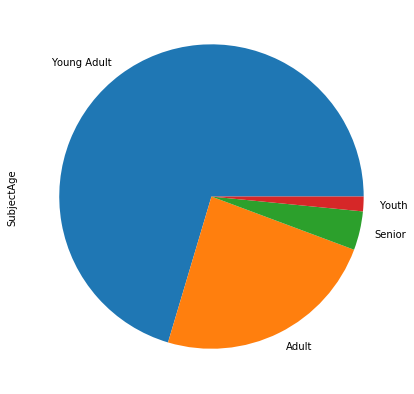

In [34]:
df_production.SubjectAge.value_counts().plot.pie(y="SubjectAge", figsize=(7, 7))

In [35]:
100*df_production.SubjectAge.value_counts()/len(df_production)

Young Adult    70.394079
Adult          23.924785
Senior          4.120824
Youth           1.560312
Name: SubjectAge, dtype: float64

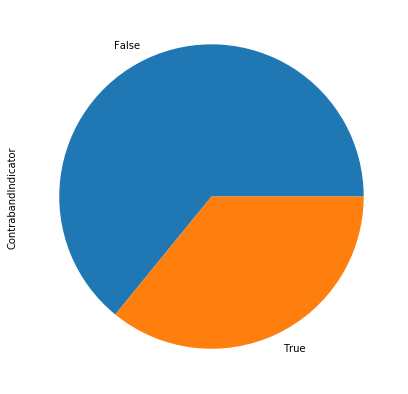

In [36]:
df_production.ContrabandIndicator.value_counts().plot.pie(y="ContrabandIndicator", figsize=(7, 7))

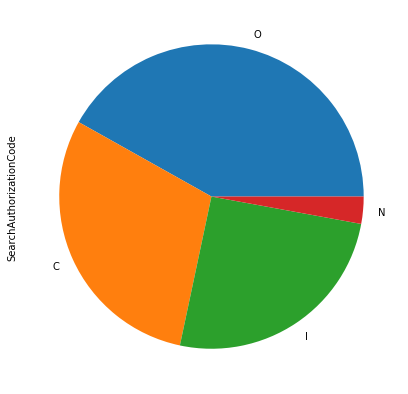

In [37]:
df_production.SearchAuthorizationCode.value_counts().plot.pie(y="SearchAuthorizationCode", figsize=(7, 7))

In [38]:
y_test = df_.true.values
y_test

array([0., 1., 1., ..., 0., 0., 1.])

In [39]:
y_pred = df_.pred.values
y_pred

array([1, 1, 1, ..., 0, 1, 1])

In [40]:
#Model Performance
score = classification_report(y_test, y_pred, labels=[0, 1])
print(score)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
cm = " tn: " + str(tn) + " fp: " + str(fp) + " fn: " + str(fn) + " tp: " + str(tp)
print(cm)

              precision    recall  f1-score   support

           0       0.75      0.03      0.06      3205
           1       0.36      0.98      0.53      1794

    accuracy                           0.37      4999
   macro avg       0.56      0.51      0.30      4999
weighted avg       0.61      0.37      0.23      4999

 tn: 108 fp: 3097 fn: 36 tp: 1758


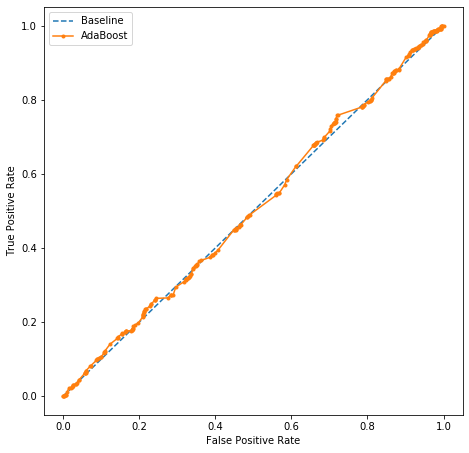

In [41]:
#Roc Curve
lr_probs = df_.prob.values
ns_probs = [0 for _ in range(len(df_.true.values))]
ns_fpr, ns_tpr, _ = roc_curve(df_.true.values, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(df_.true.values, lr_probs)
plt.figure(figsize=(7.5,7.5))
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Baseline')
plt.plot(lr_fpr, lr_tpr, marker='.', label='AdaBoost')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

In [42]:
ns_auc = roc_auc_score(df_.true.values, ns_probs)
lr_auc = roc_auc_score(df_.true.values, lr_probs)
ns_auc, lr_auc

(0.5, 0.5037804990460488)

In [43]:
bias_analysis_pred = evaluate_bias_by_group(df=df_production, group=["Department Name", "SubjectRaceCode", "SubjectEthnicityCode", "SubjectAge","SubjectSexCode"], threshold=5,  prediction=True)

/home/ines/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:3946: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


In [44]:
bias_analysis_prod_pred_diff_array = [item for sublist in bias_analysis_pred["Diff"].values for item in sublist]

In [45]:
np.mean(bias_analysis_prod_pred_diff_array), np.std(bias_analysis_prod_pred_diff_array), np.median(bias_analysis_prod_pred_diff_array), len(np.array(bias_analysis_prod_pred_diff_array)[np.array(bias_analysis_prod_pred_diff_array)<=5]), len(bias_analysis_prod_pred_diff_array)

(24.80119564345512, 19.473702110508142, 20.833333333333336, 99, 581)

In [46]:
#Distribution of amplitude for test set
df_test = pd.read_csv("resources/df_test_with_prediction.csv", index_col=0)
df_test["SubjectAge"] = df_test["SubjectAge"].apply(clean_age)
df_test["prediction"] = df_test.prediction.apply(map_prediction)
bias_analysis_pred = evaluate_bias_by_group(df=df_test, group=["Department Name", "SubjectRaceCode", "SubjectEthnicityCode", "SubjectAge","SubjectSexCode"], threshold=5,  prediction=True)
bias_analysis_pred_diff_array = [item for sublist in bias_analysis_pred["Diff"].values for item in sublist]
np.mean(bias_analysis_pred_diff_array), np.std(bias_analysis_pred_diff_array), np.median(bias_analysis_pred_diff_array), len(np.array(bias_analysis_pred_diff_array)[np.array(bias_analysis_pred_diff_array)<=5]), len(bias_analysis_pred_diff_array)

(12.89997408218525, 12.365647518459317, 9.523809523809518, 743, 2212)

In [47]:
bias_analysis_real = evaluate_bias_by_group(df=df_test, group=["Department Name", "SubjectRaceCode", "SubjectEthnicityCode", "SubjectAge","SubjectSexCode"], threshold=5)
bias_analysis_real_diff_array = [item for sublist in bias_analysis_real["Diff"].values for item in sublist]

Text(0, 0.5, 'Count')

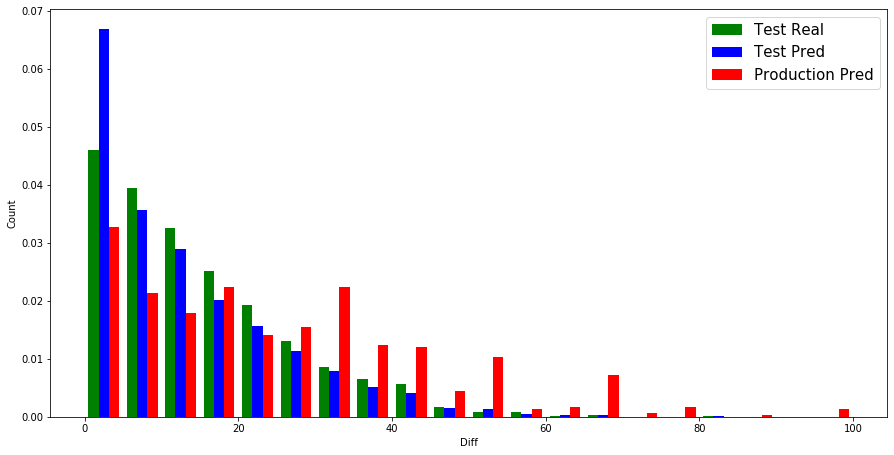

In [48]:
colors = ['green', 'blue', 'red']
plt.figure(figsize=(15,7.5))
plt.hist([bias_analysis_real_diff_array, bias_analysis_pred_diff_array, bias_analysis_prod_pred_diff_array], 20, density=True, histtype='bar', color=colors, label=["Test Real","Test Pred", "Production Pred"])
plt.legend(prop={'size': 15})
plt.xlabel("Diff")
plt.ylabel("Count")

## Results in case if we train the model only with searched vechicles

In [49]:
df_production_new_model = pd.read_csv("resources/df_test_with_prediction_production_data.csv", index_col=0)

In [50]:
df_production_new_model.groupby("SearchAuthorizationCode").prediction.value_counts()

SearchAuthorizationCode  prediction
C                        0              842
                         1              648
I                        0             1006
                         1              266
N                        0              142
                         1                2
O                        1             1155
                         0              938
Name: prediction, dtype: int64

In [51]:
df_production_new_model["ContrabandIndicator"] = df_production_new_model["ContrabandIndicator"].apply(encode_target)

In [52]:
df_production_new_model.head()

,Department Name,InterventionDateTime,InterventionLocationName,InterventionReasonCode,ReportingOfficerIdentificationID,ResidentIndicator,SearchAuthorizationCode,StatuteReason,SubjectAge,SubjectEthnicityCode,SubjectRaceCode,SubjectSexCode,TownResidentIndicator,ContrabandIndicator,prediction,probability
0,Vernon,05/16/2018 02:39:00 AM,VERNON,V,625,False,C,Registration,40.0,N,B,M,False,0,1,0.501103
1,Milford,05/16/2018 04:08:00 AM,MILFORD,E,473,True,I,Other,49.0,N,B,F,False,1,1,0.501246
2,Milford,05/16/2018 04:08:00 AM,MILFORD,E,473,True,I,Other,49.0,N,B,F,False,1,1,0.501246
3,Norwalk,05/16/2018 09:38:00 AM,NORWALK,V,100000335,True,I,Defective Lights,35.0,N,W,M,True,0,0,0.499495
4,Norwalk,05/16/2018 09:38:00 AM,NORWALK,V,100000335,True,I,Defective Lights,35.0,N,W,M,True,0,0,0.499495


In [53]:
y_pred = df_production_new_model.prediction.values
y_test = df_production_new_model.ContrabandIndicator.values

In [54]:
#Model Performance
score = classification_report(y_test, y_pred, labels=[0, 1])
print(score)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
cm = " tn: " + str(tn) + " fp: " + str(fp) + " fn: " + str(fn) + " tp: " + str(tp)
print(cm)

              precision    recall  f1-score   support

           0       0.74      0.68      0.71      3205
           1       0.50      0.58      0.54      1794

    accuracy                           0.64      4999
   macro avg       0.62      0.63      0.62      4999
weighted avg       0.66      0.64      0.65      4999

 tn: 2175 fp: 1030 fn: 753 tp: 1041


In [55]:
df_production_new_model["SubjectAge"] = df_production_new_model["SubjectAge"].apply(clean_age)

In [56]:
bias_analysis_pred_new_model = evaluate_bias_by_group(df=df_production_new_model, group=["Department Name", "SubjectRaceCode", "SubjectEthnicityCode", "SubjectAge","SubjectSexCode"], threshold=5,  prediction=True)

In [57]:
bias_analysis_pred_diff_array = [item for sublist in bias_analysis_pred_new_model["Diff"].values for item in sublist]

In [58]:
np.mean(bias_analysis_pred_diff_array), np.std(bias_analysis_pred_diff_array), np.median(bias_analysis_pred_diff_array), len(np.array(bias_analysis_pred_diff_array)[np.array(bias_analysis_pred_diff_array)<=5]), len(bias_analysis_pred_diff_array)

(29.593556774901877, 20.728337907636003, 25.0, 20, 141)

In [59]:
#Distribution of amplitude for test set For model only trainned with records with VehicleSearchedIndicator == True
df_test = pd.read_csv("resources/df_test_filtered_with_prediction_with_sac.csv", index_col=0)
df_test["SubjectAge"] = df_test["SubjectAge"].apply(clean_age)
df_test["prediction"] = df_test.prediction.apply(map_prediction)
bias_analysis_pred = evaluate_bias_by_group(df=df_test, group=["Department Name", "SubjectRaceCode", "SubjectEthnicityCode", "SubjectAge","SubjectSexCode"], threshold=5,  prediction=True)
bias_analysis_pred_diff_array = [item for sublist in bias_analysis_pred["Diff"].values for item in sublist]
np.mean(bias_analysis_pred_diff_array), np.std(bias_analysis_pred_diff_array), np.median(bias_analysis_pred_diff_array), len(np.array(bias_analysis_pred_diff_array)[np.array(bias_analysis_pred_diff_array)<=5]), len(bias_analysis_pred_diff_array)

(17.183190049916416, 12.868627264419011, 14.814814814814813, 127, 719)

In [60]:
df_test.head()

,VehicleSearchedIndicator,ContrabandIndicator,Department Name,InterventionDateTime,InterventionLocationName,InterventionReasonCode,ReportingOfficerIdentificationID,ResidentIndicator,SearchAuthorizationCode,StatuteReason,SubjectAge,SubjectEthnicityCode,SubjectRaceCode,SubjectSexCode,TownResidentIndicator,prediction
1888862,True,False,Hartford,08/16/2017 02:45:00 AM,Hartford,V,3144,True,C,Defective Lights,Young Adult,H,W,M,True,False
1724629,True,False,Stratford,05/02/2017 09:44:00 PM,STRATFORD,I,30233,True,O,Administrative Offense,Young Adult,N,B,M,True,False
2319208,True,False,Stratford,03/30/2018 09:43:00 PM,STRATFORD,V,30337,True,I,Defective Lights,Adult,H,W,M,False,False
1451171,True,False,Wallingford,10/29/2016 02:06:00 AM,WALLINGFORD,E,P188,True,O,Other,Young Adult,H,W,M,False,True
608257,True,True,Branford,10/02/2014 05:24:00 PM,Branford,V,293,True,O,Display of Plates,Young Adult,N,W,M,False,False


In [61]:
bias_analysis_real = evaluate_bias_by_group(df=df_test, group=["Department Name", "SubjectRaceCode", "SubjectEthnicityCode", "SubjectAge","SubjectSexCode"], threshold=5)
bias_analysis_real_diff_array = [item for sublist in bias_analysis_real["Diff"].values for item in sublist]

Text(0, 0.5, 'Count')

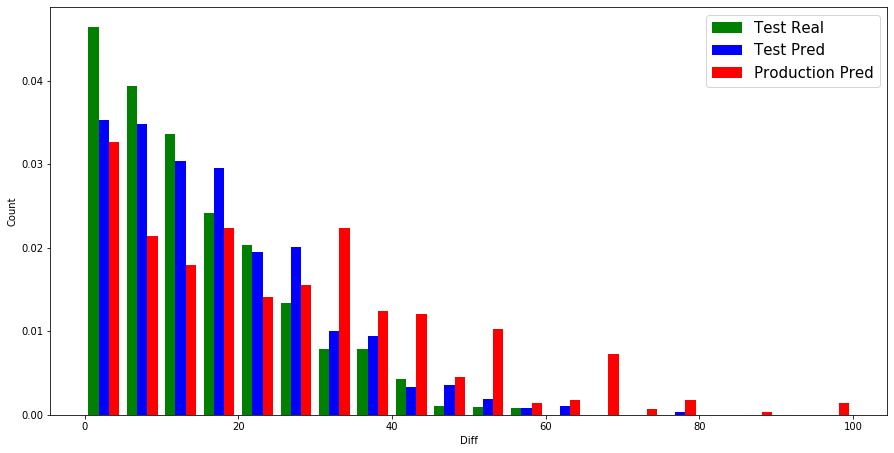

In [62]:
colors = ['green', 'blue', 'red']
plt.figure(figsize=(15,7.5))
plt.hist([bias_analysis_real_diff_array, bias_analysis_pred_diff_array, bias_analysis_prod_pred_diff_array], 20, density=True, histtype='bar', color=colors, label=["Test Real","Test Pred", "Production Pred"])
plt.legend(prop={'size': 15})
plt.xlabel("Diff")
plt.ylabel("Count")

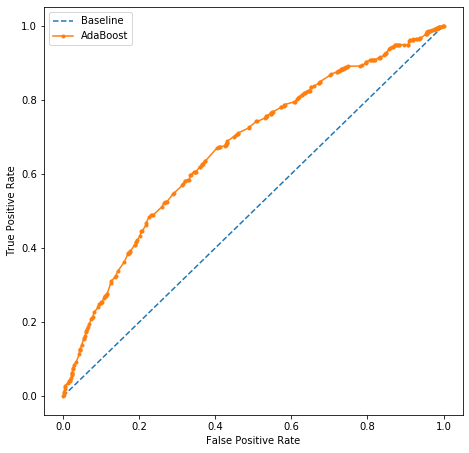

In [63]:
lr_probs = df_production_new_model.probability.values
ns_probs = [0 for _ in range(len(y_test))]
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
plt.figure(figsize=(7.5,7.5))
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Baseline')
plt.plot(lr_fpr, lr_tpr, marker='.', label='AdaBoost')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

In [64]:
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
ns_auc, lr_auc

(0.5, 0.6676933164283092)

## Population analysis on test set

In [65]:
df_test = pd.read_csv("resources/df_test.csv", index_col=0)
df_test["SubjectAge"] = df_test["SubjectAge"].apply(clean_age)

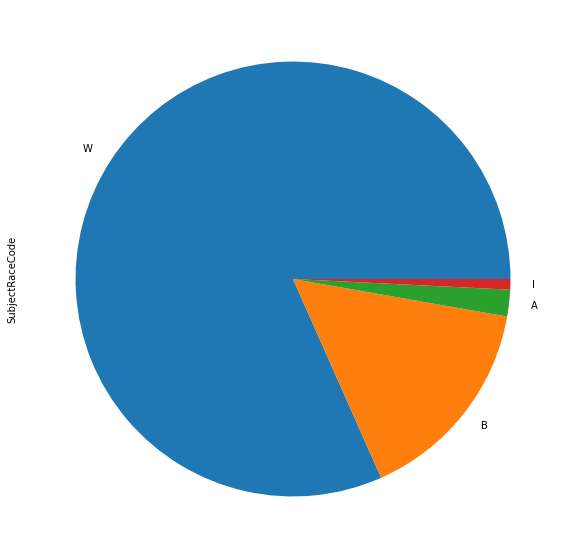

In [66]:
df_test.SubjectRaceCode.value_counts().plot.pie(y="SubjectRaceCode", figsize=(10, 10))

In [67]:
100*df_test.SubjectRaceCode.value_counts()/len(df_test)

W    81.642071
B    15.596417
A     1.977244
I     0.784268
Name: SubjectRaceCode, dtype: float64

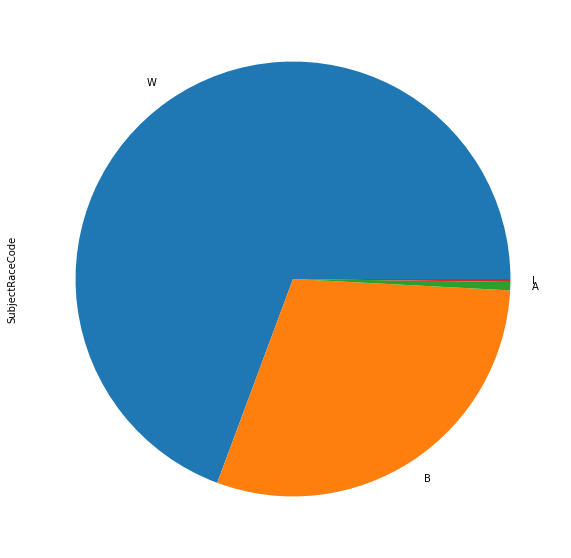

In [68]:
df_test[df_test["VehicleSearchedIndicator"]==True].SubjectRaceCode.value_counts().plot.pie(y="SubjectRaceCode", figsize=(10, 10))

In [69]:
100*df_test[df_test["VehicleSearchedIndicator"]==True].SubjectRaceCode.value_counts()/len(df_test[df_test["VehicleSearchedIndicator"]==True])

W    69.334550
B    29.831193
A     0.619175
I     0.215082
Name: SubjectRaceCode, dtype: float64

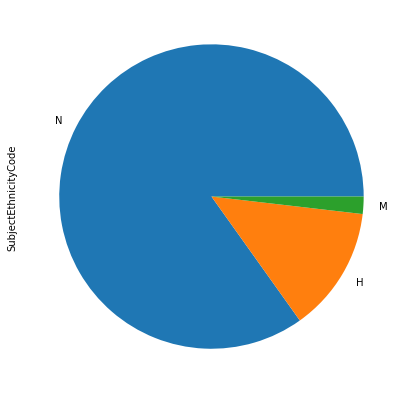

In [70]:
df_test.SubjectEthnicityCode.value_counts().plot.pie(y="SubjectEthnicityCode", figsize=(7, 7))

In [71]:
100*df_test.SubjectEthnicityCode.value_counts()/len(df_test)

N    84.857973
H    13.306275
M     1.835753
Name: SubjectEthnicityCode, dtype: float64

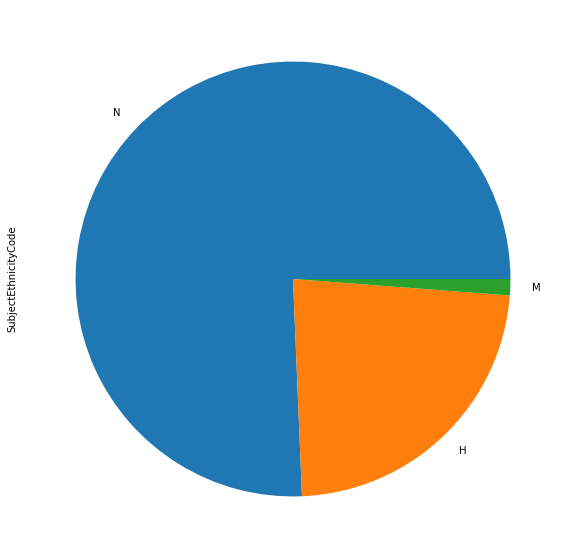

In [72]:
df_test[df_test["VehicleSearchedIndicator"]==True].SubjectEthnicityCode.value_counts().plot.pie(y="SubjectEthnicityCode", figsize=(10, 10))

In [73]:
100*df_test[df_test["VehicleSearchedIndicator"]==True].SubjectEthnicityCode.value_counts()/len(df_test[df_test["VehicleSearchedIndicator"]==True])

N    75.656651
H    23.137587
M     1.205762
Name: SubjectEthnicityCode, dtype: float64

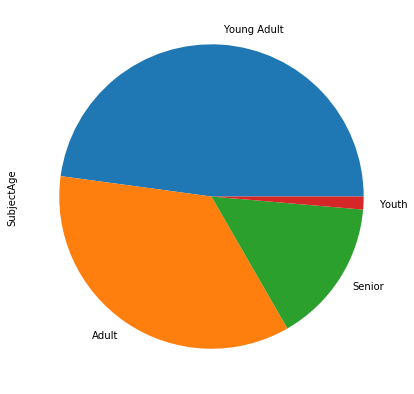

In [74]:
df_test.SubjectAge.value_counts().plot.pie(y="SubjectAge", figsize=(7, 7))

In [75]:
100*df_test.SubjectAge.value_counts()/len(df_test)

Young Adult    47.857716
Adult          35.455573
Senior         15.315456
Youth           1.371256
Name: SubjectAge, dtype: float64

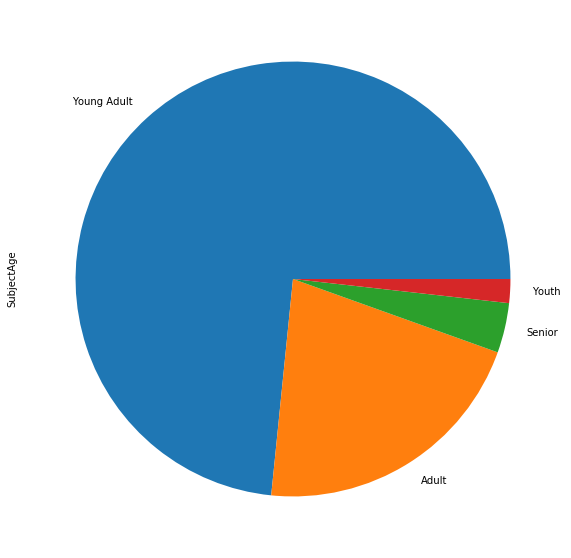

In [76]:
df_test[df_test["VehicleSearchedIndicator"]==True].SubjectAge.value_counts().plot.pie(y="SubjectAge", figsize=(10, 10))

In [77]:
100*df_test[df_test["VehicleSearchedIndicator"]==True].SubjectAge.value_counts()/len(df_test[df_test["VehicleSearchedIndicator"]==True])

Young Adult    73.401551
Adult          21.123639
Senior          3.702014
Youth           1.772795
Name: SubjectAge, dtype: float64

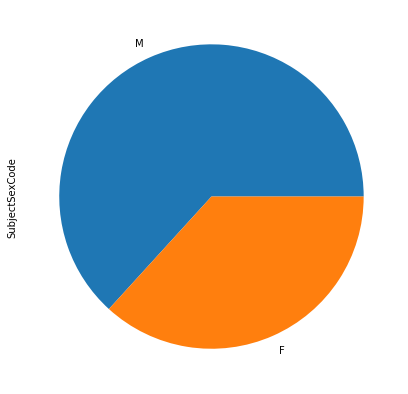

In [78]:
df_test.SubjectSexCode.value_counts().plot.pie(y="SubjectSexCode", figsize=(7, 7))

In [79]:
100*df_test.SubjectSexCode.value_counts()/len(df_test)

M    63.234215
F    36.765785
Name: SubjectSexCode, dtype: float64

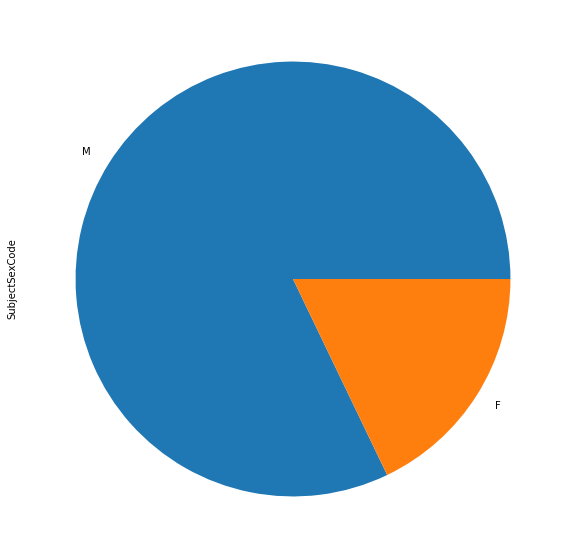

In [80]:
df_test[df_test["VehicleSearchedIndicator"]==True].SubjectSexCode.value_counts().plot.pie(y="SubjectSexCode", figsize=(10, 10))

In [81]:
100*df_test[df_test["VehicleSearchedIndicator"]==True].SubjectSexCode.value_counts()/len(df_test[df_test["VehicleSearchedIndicator"]==True])

M    82.128658
F    17.871342
Name: SubjectSexCode, dtype: float64